In [154]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import io
import sys

from IPython.display import display

## Data cleaning and preparation

In [2]:
!wget https://github.com/gastonstat/CreditScoring/raw/master/CreditScoring.csv

--2023-10-23 15:49:26--  https://github.com/gastonstat/CreditScoring/raw/master/CreditScoring.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gastonstat/CreditScoring/master/CreditScoring.csv [following]
--2023-10-23 15:49:26--  https://raw.githubusercontent.com/gastonstat/CreditScoring/master/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: 'CreditScoring.csv'

     0K .......... .......... .......... .......... .......... 28% 1.16M 0s
    50K .......... .......... .......... .......... .......... 56% 3.53M 0s
   100K ..

In [3]:
df = pd.read_csv("CreditScoring.csv")
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:
df.columns = df.columns.str.lower()

In [5]:
status_values = {1: "ok", 2: "default", 0: "unknown"}
df.status = df.status.map(status_values)

home_values = {
    1: "rent",
    2: "owner",
    3: "private",
    4: "ignore",
    5: "parents",
    6: "other",
    0: "unknown",
}
df.home = df.home.map(home_values)

marital_values = {
    1: "single",
    2: "married",
    3: "widow",
    4: "separated",
    5: "divorced",
    0: "unknown",
}
df.marital = df.marital.map(marital_values)

records_values = {1: "no", 2: "yes", 0: "unknown"}
df.records = df.records.map(records_values)

job_values = {1: "fixed", 2: "partime", 3: "freelance", 4: "others", 0: "unknown"}
df.job = df.job.map(job_values)

In [6]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [8]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [10]:
for col in ["income", "assets", "debt"]:
    df[col].replace(to_replace=99999999, value=np.nan, inplace=True)

In [11]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [12]:
df.status.value_counts()

status
ok         3200
default    1254
unknown       1
Name: count, dtype: int64

In [13]:
# Remove clients with unknown status
df = df[df.status != "unknown"].reset_index(drop=True)

In [18]:
# Split dataset into train, val, and test
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [19]:
# Get target variable
y_train = (df_train.status == "default").astype("int").values
y_val = (df_val.status == "default").astype("int").values
y_test = (df_test.status == "default").astype("int").values

In [20]:
# Remove target variable from datasets
del df_train["status"]
del df_val["status"]
del df_test["status"]

## Decision trees

- How a decision tree looks like
- How to build a decision tree
- Overfitting and underfitting
- Controlling the size of a tree

In [25]:
train_dicts = df_train.fillna(0).to_dict(orient="records")
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [27]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [28]:
val_dicts = df_val.fillna(0).to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [31]:
# Accuracy in the training dataset
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

In [30]:
# Accuracy in the validation dataset
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6553274321280667

In [52]:
# Try a new model controlling the depth of the tree
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [53]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_pred)

y_pred = dt.predict_proba(X_val)[:, 1]
auc_val = roc_auc_score(y_val, y_pred)
roc_auc_score(y_val, y_pred)

print(f"Train: {auc_train:.4f}")
print(f"Validation: {auc_val:.4f}")

Train: 0.7761
Validation: 0.7389


In [54]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0



## Decision tree learning algorithm

- Finding the best split for one feature
- Finding the best split for the entire dataset
- Stopping criteria
- Decision tree learning algorithm

In [58]:
data = [
    [8000, "default"],
    [2000, "default"],
    [0, "default"],
    [5000, "ok"],
    [5000, "ok"],
    [4000, "ok"],
    [9000, "ok"],
    [3000, "default"],
]

df_example = pd.DataFrame(data, columns=["assets", "status"])
df_example.sort_values("assets", inplace=True)

In [66]:
Ts = [2000, 3000, 4000, 5000, 8000]
ls_out = []
for T in Ts:
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    # Estimate missclassification rate for each split
    print(T)
    decision_left = df_left.status.mode()[0]
    impurity_left = 1 - (df_left.status == decision_left).mean()
    decision_right = df_right.status.mode()[0]
    impurity_right = 1 - (df_right.status == decision_right).mean()
    mean_impurity = (
        len(df_left) * impurity_left + len(df_right) * impurity_right
    ) / len(df_example)
    # Append list of results to dataframe
    ls_out.append(
        {
            "T": T,
            "impurity_left": impurity_left,
            "impurity_right": impurity_right,
            "mean_impurity": mean_impurity,
        }
    )
df_out = pd.DataFrame(ls_out)

2000
3000
4000
5000
8000


In [72]:
# Decision tree example with two features
data = [
    [8000, 3000, "default"],
    [2000, 1000, "default"],
    [0, 1000, "default"],
    [5000, 1000, "ok"],
    [5000, 1000, "ok"],
    [4000, 1000, "ok"],
    [9000, 500, "ok"],
    [3000, 2000, "default"],
]
df_example = pd.DataFrame(data, columns=["assets", "debt", "status"])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [73]:
df_example.sort_values("debt")

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [78]:
thresholds = {
    "assets": [2000, 3000, 4000, 5000, 8000],
    "debt": [500, 1000, 2000],
}
ls_out = []
for feature, Ts in thresholds.items():
    for T in Ts:
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]
        # Estimate missclassification rate for each split
        decision_left = df_left.status.mode()[0]
        impurity_left = 1 - (df_left.status == decision_left).mean()
        decision_right = df_right.status.mode()[0]
        impurity_right = 1 - (df_right.status == decision_right).mean()
        mean_impurity = (
            len(df_left) * impurity_left + len(df_right) * impurity_right
        ) / len(df_example)
        # Append list of results to dataframe
        ls_out.append(
            {
                "Feature": feature,
                "T": T,
                "impurity_left": impurity_left,
                "impurity_right": impurity_right,
                "mean_impurity": mean_impurity,
            }
        )
df_out = pd.DataFrame(ls_out)
df_out

,Feature,T,impurity_left,impurity_right,mean_impurity
0,assets,2000,0.000000,0.333333,0.250
1,assets,3000,0.000000,0.200000,0.125
2,assets,4000,0.250000,0.250000,0.250
3,assets,5000,0.500000,0.500000,0.500
4,assets,8000,0.428571,0.000000,0.375
5,debt,500,0.000000,0.428571,0.375
6,debt,1000,0.333333,0.000000,0.250
7,debt,2000,0.428571,0.000000,0.375


### Finding the best split for the entire dataset

For each feature in the dataset, the algorithm looks for the best split. It then selects the feature and the split that produce the purest subsets (weighted by their size). The subset that is the purest (has the lowest impurity) is selected to make the split, and the algorithm moves on to the next level, repeating the process until it reaches the maximum depth (defined by the max_depth hyperparameter), or it cannot find a split that will reduce impurity. 

### Stopping criteria

- Maximum depth: The maximum depth of a decision tree is defined by the max_depth hyperparameter. Reducing max_depth will regularize the model and thus reduce the risk of overfitting.
- Minimum number of samples per leaf node: The min_samples_leaf hyperparameter controls the minimum number of samples that a leaf node can have. If a split results in a leaf node with fewer samples than min_samples_leaf, the split is discarded.
- Maximum number of leaf nodes: The max_leaf_nodes hyperparameter controls the maximum number of leaf nodes. Reducing this number will regularize the model.
- Minimum impurity split: The min_impurity_split hyperparameter threshold for early stopping based on a node's impurity. A split is evaluated only if it decreases the impurity by at least this threshold. Reducing this threshold will regularize the model.

### Decision tree learning algorithm

- Start at the root node, which contains the entire dataset.
- Find the best split for the entire dataset.
- Split the dataset into two subsets using the best split.
- Repeat the process on each subset until you reach the maximum depth, or until it cannot find a split that will reduce impurity.

## Decision trees parameter tuning

- Selecting max_depth
- Selecting min_samples_leaf

In [81]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print("%4s --> %.3f" % (d, auc))

   1 --> 0.606
   2 --> 0.669
   3 --> 0.739
   4 --> 0.761
   5 --> 0.767
   6 --> 0.754
  10 --> 0.686
  15 --> 0.674
  20 --> 0.666
None --> 0.662


In [92]:
scores = []
for d in [4, 5, 6, 7, 10, 15, 20, None]:
    for s in [1, 2, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append({"max_depth": d, "min_samples_leaf": s, "auc": auc})
df_scores = pd.DataFrame(scores)
df_scores.sort_values("auc", ascending=False).head()

,max_depth,min_samples_leaf,auc
40,10.0,15,0.789779
67,NaN,15,0.787823
49,15.0,15,0.787393
22,6.0,15,0.785319
58,20.0,15,0.785135


In [93]:
df_scores_pivot = df_scores.pivot(
    index="min_samples_leaf", columns="max_depth", values="auc"
)
df_scores_pivot.round(3)

max_depth,NaN,4.0,5.0,6.0,7.0,10.0,15.0,20.0
min_samples_leaf,,,,,,,,
1,0.658,0.761,0.766,0.747,0.743,0.699,0.661,0.650
2,0.689,0.761,0.766,0.755,0.756,0.720,0.685,0.692
5,0.720,0.761,0.768,0.762,0.757,0.731,0.714,0.718
10,0.761,0.761,0.762,0.778,0.765,0.768,0.765,0.761
15,0.788,0.764,0.772,0.785,0.780,0.790,0.787,0.785
20,0.785,0.761,0.774,0.773,0.781,0.785,0.781,0.782
50,0.776,0.753,0.768,0.772,0.776,0.778,0.776,0.776
100,0.780,0.756,0.763,0.776,0.780,0.779,0.779,0.779
200,0.768,0.747,0.759,0.768,0.768,0.768,0.768,0.768


<Axes: xlabel='max_depth', ylabel='min_samples_leaf'>

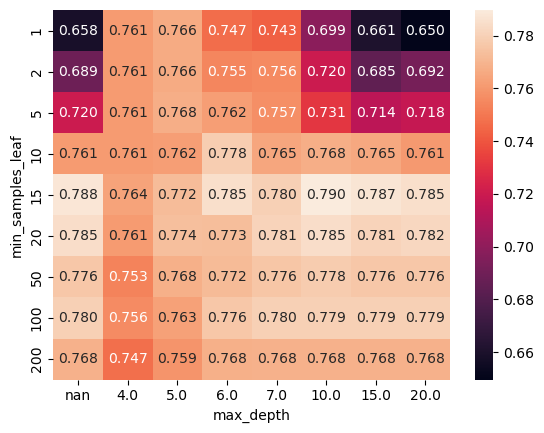

In [94]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [95]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

## Ensembles and random forest

- Board of experts: it is random because each expert is trained on a random subset of the training data. And it is a forest because it is composed of many trees. 
- Ensembling models: the idea is to train several models on the same dataset, and then to combine their predictions. The combined predictions are usually better than the predictions of any individual model because the models complement each other. This is called ensembling.
- Random forest - ensembling decision trees: the random forest algorithm is an ensemble of decision trees. It is a collection of decision trees that have been trained on random subsets of the training data using random subsets of the features. The predictions of all the trees are then averaged to produce the final prediction.
- Tuning random forest: the random forest algorithm has many hyperparameters that you can tune. The most important ones are:
    - n_estimators: The n_estimators hyperparameter controls the number of trees in the forest. Increasing n_estimators will reduce overfitting.
    - max_depth: The max_depth hyperparameter controls the maximum depth of each tree in the forest. Reducing max_depth will reduce overfitting.
    - min_samples_leaf: The min_samples_leaf hyperparameter controls the minimum number of samples that a leaf node can have. Increasing min_samples_leaf will reduce overfitting.
    - max_features: The max_features hyperparameter controls the number of features that are randomly selected for each split. Increasing max_features will reduce overfitting.
    - bootstrap: The bootstrap hyperparameter controls whether the subsets are created using sampling with replacement (when set to True), or without replacement (when set to False). Setting bootstrap to False will generally reduce overfitting.

In [97]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7744726453706618

In [100]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append({"n_estimators": n, "auc": auc})
df_scores = pd.DataFrame(scores)
df_scores.sort_values("auc", ascending=False).head()

,n_estimators,auc
19,200,0.819050
12,130,0.818253
13,140,0.818102
18,190,0.817981
15,160,0.817981


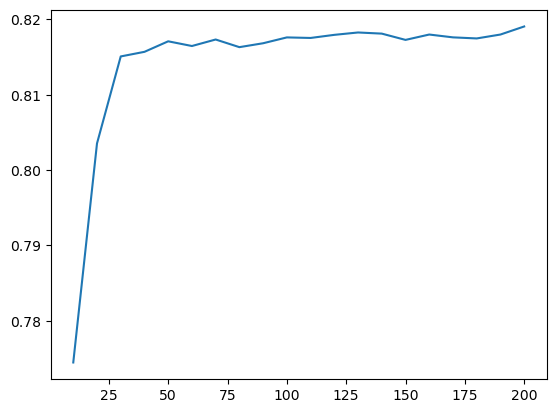

In [99]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [101]:
scores = []
for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(max_depth=d, n_estimators=n, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append({"max_depth": d, "n_estimators": n, "auc": auc})
df_scores = pd.DataFrame(scores)
df_scores.sort_values("auc", ascending=False).head()

,max_depth,n_estimators,auc
35,10,160,0.825243
39,10,200,0.824923
37,10,180,0.824801
36,10,170,0.824632
38,10,190,0.824535


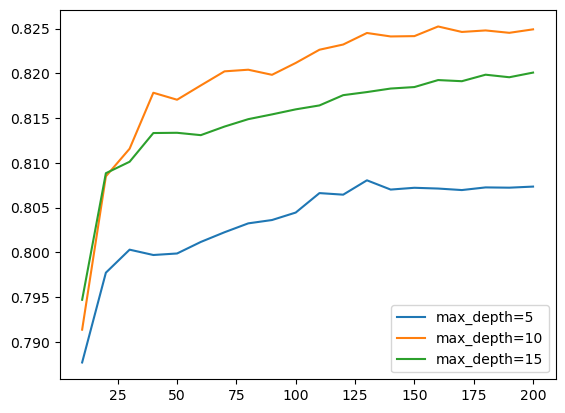

In [104]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label="max_depth=%d" % d)
plt.legend()

In [ ]:
max_depth = 10

In [105]:
scores = []
for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(
            max_depth=d, n_estimators=n, min_samples_leaf=s, random_state=1
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append({"min_samples_leaf": s, "n_estimators": n, "auc": auc})
df_scores = pd.DataFrame(scores)
df_scores.sort_values("auc", ascending=False).head()

,min_samples_leaf,n_estimators,auc
38,3,190,0.828719
39,3,200,0.828622
35,3,160,0.828501
37,3,180,0.827859
34,3,150,0.827823


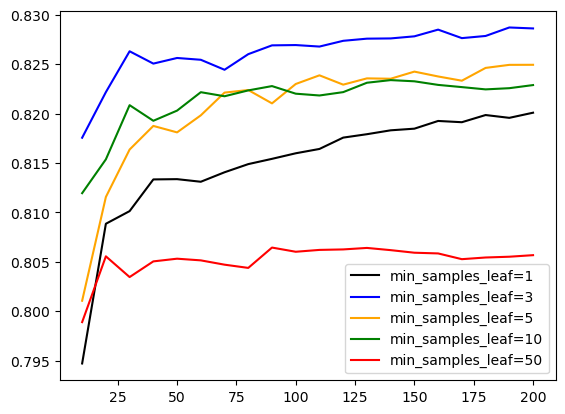

In [108]:
colors = ["black", "blue", "orange", "green", "red"]
min_samples_leaf_values = [1, 3, 5, 10, 50]
for s, color in zip(min_samples_leaf_values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(
        df_subset.n_estimators,
        df_subset.auc,
        label="min_samples_leaf=%d" % s,
        color=color,
    )
plt.legend()

In [109]:
rf = RandomForestClassifier(
    max_depth=10,
    n_estimators=100,
    min_samples_leaf=3,
    random_state=1,
)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
auc

0.8233361991717324

## Gradient boosting and XGBoost

### Gradient boosting vs random forest

The main difference between gradient boosting and random forest is that gradient boosting is an additive model, while random forest is a parallel model. In gradient boosting, each tree is built on the errors of the previous tree. In random forest, all trees are built independently of each other. XGboost is an optimized implementation of gradient boosting in Python.

In detail, the gradient boosting algorithm works as follows:
- Start with a single decision tree.
- Find the errors of the decision tree.
- Build a new decision tree that will predict the errors of the previous tree.
- Add the new decision tree to the ensemble.
- Repeat steps 2 to 4 until the ensemble is good enough.

The objective function of a XGBoost model is the sum of two terms: the loss term and the regularization term. The loss term measures how predictive the model is on the training data. The regularization term penalizes the complexity of the model, to avoid overfitting. The objective function is minimized to find the best model. This is done using gradient descent optimization. At each iteration, XGBoost fits a tree to the gradient loss function, effectively reducing the residuals (errors) from the previous trees.

In [110]:
# !pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/32/10/4689bda37403f7dd029d550c4446e0097c2f33b8ae877b235e76d5c49bc2/xgboost-2.0.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.7 MB 393.8 kB/s eta 0:04:14
   ---------------------------------------- 0.1/99.7 MB 1.1 MB/s eta 0:01:34
   ---------------------------------------- 0.4/99.7 MB 2.3 MB/s eta 0:00:43
   ---------------------------------------- 1.1/99.7 MB 5.0 MB/s eta 0:00:20
    --------------------------------------- 2.2/99.7 MB 8.2 MB/s eta 0:00:12
   - -------------------------------------- 3.6/99.7 MB 11.6 MB/s eta 0:00:09
   -- ------------------------------------- 5.2/99.7 MB 14.5 MB/s eta 0:00:07
   -- ------------------------------------- 6.8/99.7 MB 16.7 MB/s eta 0:00:06
   --- ---------------------------

In [134]:
features = dv.feature_names_
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [135]:
watchlist = [(dtrain, "train"), (dval, "val")]

In [136]:
%%capture output

xgb_params = {
    "eta": 0.3,  # Learning rate
    "max_depth": 6,  # Max depth of the tree
    "min_child_weight": 1,  # It is similar to min_samples_leaf
    "objective": "binary:logistic",  # It is similar to criterion
    "eval_metric": "auc",  # It is similar to scoring
    "nthread": 8,  # Number of cores
    "seed": 1,
    "verbosity": 1,
}
model = xgb.train(
    xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200
)

In [167]:
def parse_xgb_output(output):
    # If stdout attribute doesn't exist, then take the whole output
    if not hasattr(output, "stdout"):
        output = output
    else:
        output = output.stdout
    results = []
    for line in output.strip().split("\n"):
        it_line, train_line, val_line = line.split("\t")
        it = int(it_line.strip("[]"))
        train = train_line.split(":")[1]
        val = val_line.split(":")[1]

        results.append(
            {
                "num_iteration": it,
                "train_auc": float(train),
                "val_auc": float(val),
            }
        )
    return pd.DataFrame(results)

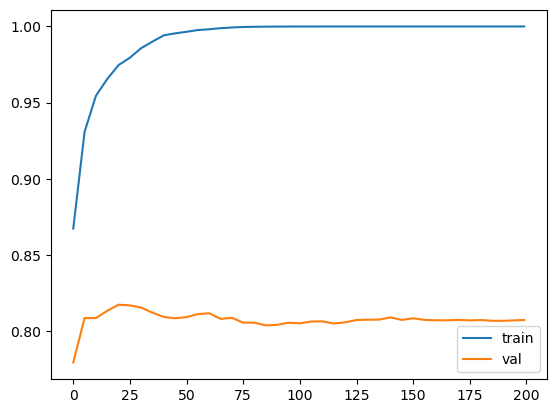

In [138]:
df_score = parse_xgb_output(output)
plt.plot(df_score.num_iteration, df_score.train_auc, label="train")
plt.plot(df_score.num_iteration, df_score.val_auc, label="val")
plt.legend()

In [139]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8072491584122448

## XGBoost parameter tuning

The main hyperparameters of XGBoost are:
- learning_rate: The learning rate controls how much each tree is allowed to correct the errors of the previous trees. A low learning rate will require more trees in the ensemble, but the predictions will usually be better. Reducing learning_rate will reduce overfitting.
- max_depth: The max_depth hyperparameter controls the maximum depth of each tree in the ensemble. Reducing max_depth will reduce overfitting.
- min_child_weight: The min_child_weight hyperparameter controls the minimum number of samples that a leaf node can have. Increasing min_child_weight will reduce overfitting.
- subsample: The subsample hyperparameter controls the fraction of samples that is used for training each tree. Reducing subsample will reduce overfitting.
- colsample_bytree: The colsample_bytree hyperparameter controls the fraction of features that is used for training each tree. Reducing colsample_bytree will reduce overfitting. 
- lambda: The lambda hyperparameter controls the L2 regularization term. Increasing lambda will reduce overfitting.
- alpha: The alpha hyperparameter controls the L1 regularization term. Increasing alpha will reduce overfitting.

### Tunning Learning Rate

In [174]:
scores = {}
for eta in [0.01, 0.05, 0.1, 0.3, 0.5, 0.75, 0.9, 1]:
    with io.StringIO() as buf:
        xgb_params = {
            "eta": eta,  # Learning rate
            "max_depth": 6,  # Max depth of the tree
            "min_child_weight": 1,  # It is similar to min_samples_leaf
            "objective": "binary:logistic",  # It is similar to criterion
            "eval_metric": "auc",
            "nthread": 8,  # Number of cores
            "seed": 1,
            "verbosity": 1,
        }
        sys.stdout = buf  # Redirect standard output to the buffer
        model = xgb.train(
            xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200
        )
        sys.stdout = sys.__stdout__  # Restore standard output
        output = buf.getvalue()  # Get the captured output from the buffer
        scores["eta=%s" % eta] = parse_xgb_output(output)

In [188]:
selected_scores = {
    key: value
    for key, value in scores.items()
    if key in ["eta=0.01", "eta=0.05", "eta=0.1", "eta=0.3", "eta=1"]
}

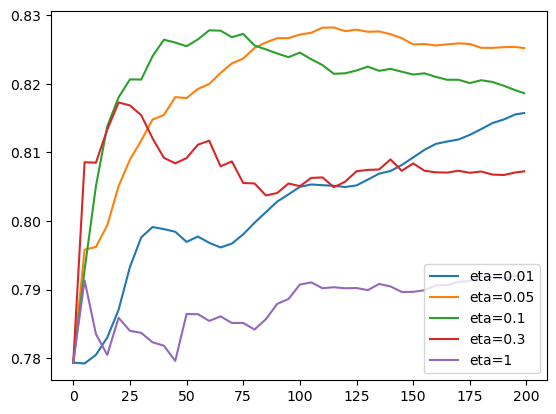

In [189]:
for key, df_score in selected_scores.items():
    plt.plot(df_score.num_iteration, df_score.val_auc, label=key)
plt.legend()

### Tunning max_depth

In [190]:
scores = {}
for max_depth in [3, 4, 5, 6, 7, 10]:
    with io.StringIO() as buf:
        xgb_params = {
            "eta": 0.1,  # Learning rate
            "max_depth": max_depth,  # Max depth of the tree
            "min_child_weight": 1,  # It is similar to min_samples_leaf
            "objective": "binary:logistic",  # It is similar to criterion
            "eval_metric": "auc",
            "nthread": 8,  # Number of cores
            "seed": 1,
            "verbosity": 1,
        }
        sys.stdout = buf  # Redirect standard output to the buffer
        model = xgb.train(
            xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200
        )
        sys.stdout = sys.__stdout__  # Restore standard output
        output = buf.getvalue()  # Get the captured output from the buffer
        scores["max_depth=%s" % max_depth] = parse_xgb_output(output)

In [191]:
selected_scores = {
    key: value
    for key, value in scores.items()
    if key in ["max_depth=3", "max_depth=4", "max_depth=6", "max_depth=10"]
}

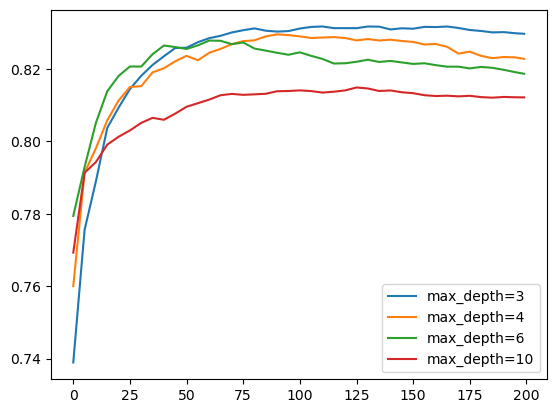

In [192]:
for key, df_score in selected_scores.items():
    plt.plot(df_score.num_iteration, df_score.val_auc, label=key)
plt.legend()

### Tunning min_child_weight

In [195]:
scores = {}
for min_child_weight in [1, 10, 30]:
    with io.StringIO() as buf:
        xgb_params = {
            "eta": 0.1,  # Learning rate
            "max_depth": 3,  # Max depth of the tree
            "min_child_weight": min_child_weight,  # It is similar to min_samples_leaf
            "objective": "binary:logistic",  # It is similar to criterion
            "eval_metric": "auc",
            "nthread": 8,  # Number of cores
            "seed": 1,
            "verbosity": 1,
        }
        sys.stdout = buf  # Redirect standard output to the buffer
        model = xgb.train(
            xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200
        )
        sys.stdout = sys.__stdout__  # Restore standard output
        output = buf.getvalue()  # Get the captured output from the buffer
        scores["min_child_weight=%s" % min_child_weight] = parse_xgb_output(output)

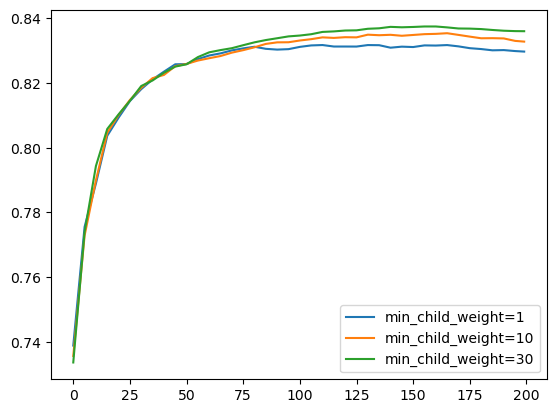

In [196]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iteration, df_score.val_auc, label=key)
plt.legend()

### Final XGBoost model

In [ ]:
xgb_params = {
    "eta": 0.1,  # Learning rate
    "max_depth": 3,  # Max depth of the tree
    "min_child_weight": 30,  # It is similar to min_samples_leaf
    "objective": "binary:logistic",  # It is similar to criterion
    "eval_metric": "auc",
    "nthread": 8,  # Number of cores
    "seed": 1,
    "verbosity": 1,
}
sys.stdout = buf  # Redirect standard output to the buffer
model = xgb.train(
    xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=175
)
sys.stdout = sys.__stdout__  # Restore standard output
output = buf.getvalue()  # Get the captured output from the buffer
scores["min_child_weight=%s" % min_child_weight] = parse_xgb_output(output)

## Selecting the final model

- Choosing between xgboost, random forest and decision tree
- Training the final model
- Saving the model

In [198]:
# Decision Tree model
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7854738320699426

In [199]:
# Random forest model
rf = RandomForestClassifier(
    max_depth=10,
    n_estimators=200,
    min_samples_leaf=3,
    random_state=1,
)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [201]:
# XGBoost model
xgb_params = {
    "eta": 0.1,  # Learning rate
    "max_depth": 3,  # Max depth of the tree
    "min_child_weight": 30,  # It is similar to min_samples_leaf
    "objective": "binary:logistic",  # It is similar to criterion
    "eval_metric": "auc",
    "nthread": 8,  # Number of cores
    "seed": 1,
    "verbosity": 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=175)
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.836632074786273

## Training model with full training dataset

In [ ]:
# Data preparation
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = (df_full_train.status == "default").astype("int").values
del df_full_train["status"]
dicts_full_train = df_full_train.fillna(0).to_dict(orient="records")
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)
dicts_test = df_test.fillna(0).to_dict(orient="records")
X_test = dv.transform(dicts_test)

In [205]:
# Preparing matrix for XGBoost
dfulltrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dtest = xgb.DMatrix(X_test, feature_names=dv.feature_names_)

# Model training
xgb_params = {
    "eta": 0.1,  # Learning rate
    "max_depth": 3,  # Max depth of the tree
    "min_child_weight": 30,  # It is similar to min_samples_leaf
    "objective": "binary:logistic",  # It is similar to criterion
    "eval_metric": "auc",
    "nthread": 8,  # Number of cores
    "seed": 1,
    "verbosity": 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

0.8276171741361614

## Summary

- Decision trees learn if-then-else rules from data. They are easy to interpret and to visualize. They tend to easily overfit the training data if they are not regularized.
- Finding the best split: the algorithm looks for the best split for each feature. It then selects the feature and the split that produce the purest subsets (weighted by their size). The metrics used to measure impurity are entropy and the Gini index for classification, and the MSE for regression.
- Stopping criteria: the algorithm stops when it reaches the maximum depth (defined by the max_depth hyperparameter), or when it cannot find a split that will reduce impurity.
- Random forest is a way of training multiple decision trees on different subsets of the training data, and then averaging their predictions. It generally produces much better predictions than a single decision tree and reduces overfitting.
- Gradient boosting is a way of training multiple decision trees sequentially, with each tree learning from the errors of the previous trees. It generally produces much better predictions than a single decision tree and reduces overfitting. XGBoost is an optimized implementation of gradient boosting.

## Explore more

- For this dataset, we didn't do EDA or feature engineering. You can do it to get more insights into the problem.
- For random forest, there are more parameters that we can tune. Check max_features and bootstrap.
- There is a variation of random forest called "extremely randomized trees" or "extra trees". Instead of selecting the best split among all possible thresholds, it selects a few thresholds at random and then selects the best split among them. This extra randomness acts as a form of regularization and often produces better predictions. You can try it by setting the bootstrap hyperparameter to False, and by using the ExtraTreesClassifier class instead of the RandomForestClassifier class.
- XGBoost can deal with missing values. You can try to impute the missing values in the dataset and see if it improves the performance of the model.
- Experiment with other XGBoost parameters such as subsample, colsample_bytree, lambda, and alpha.
- When selecting the best split, decision trees find the most useful features. This information can be used for understanding which features are more important than others.
- Trees can also be used for solving regression problems: check DecisionTreeRegressor, RandomForestRegressor, and the objective="reg:squarederror" parameter for XGBoost.